In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv(r'G:\GitHub\Kaggle Tokyo Stock Exchange\jpx-tokyo-stock-exchange-prediction\train_files\stock_prices.csv')
df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [3]:
#convert date from string to datetime type
df.loc[: ,"Date"] = pd.to_datetime(df.loc[: ,"Date"], format="%Y-%m-%d")

In [4]:
df.index=df.pop('Date')

### Let's take dive into a particular security :Toyota

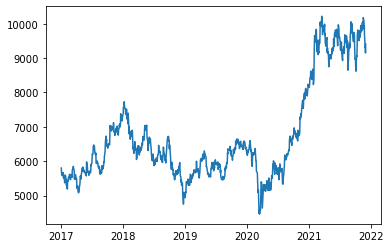

In [5]:
df_toyota = df[df['SecuritiesCode']==6201]

plt.plot(df_toyota.index, df_toyota.Close);

In [6]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [7]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df_toyota, 
                                '2020-12-03', 
                                '2021-12-03', 
                                n=5)
windowed_df

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2020-12-03,7770.0,7760.0,7540.0,7580.0,7750.0,7850.0
1,2020-12-04,7760.0,7540.0,7580.0,7750.0,7850.0,7880.0
2,2020-12-07,7540.0,7580.0,7750.0,7850.0,7880.0,7980.0
3,2020-12-08,7580.0,7750.0,7850.0,7880.0,7980.0,7900.0
4,2020-12-09,7750.0,7850.0,7880.0,7980.0,7900.0,7810.0
...,...,...,...,...,...,...,...
241,2021-11-29,10180.0,10110.0,9940.0,9940.0,9680.0,9400.0
242,2021-11-30,10110.0,9940.0,9940.0,9680.0,9400.0,9320.0
243,2021-12-01,9940.0,9940.0,9680.0,9400.0,9320.0,9330.0
244,2021-12-02,9940.0,9680.0,9400.0,9320.0,9330.0,9150.0


In [8]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((246,), (246, 5, 1), (246,))

In [9]:
from sklearn.preprocessing import MinMaxScaler

X_flat = X.reshape(X.shape[0], -1)  # This will flatten the timesteps while keeping the samples intact

# Now apply the MinMaxScaler
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_flat)
y_scaled = min_max_scaler.fit_transform(y.reshape(-1, 1))
# reshape it back
X_scaled_reshaped = X_scaled.reshape(X.shape[0], X.shape[1], -1)


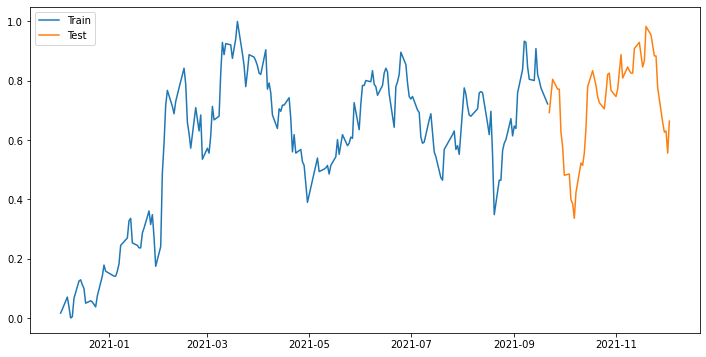

In [10]:
# Calculate the length of the training data by taking 80% of the total length of the 'date' array
q_80 = int(len(dates) * .8)

dates_train, X_train, y_train = dates[:q_80], X_scaled_reshaped[:q_80], y_scaled[:q_80]

dates_test, X_test, y_test = dates[q_80:], X_scaled_reshaped[q_80:], y_scaled[q_80:]

plt.figure(figsize=(12,6))
plt.plot(dates_train, y_train)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Test'])

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(100),
                    layers.Dense(50, activation='relu'),
                    layers.Dense(50, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 8ms/step - loss: 0.3151 - mean_absolute_error: 0.5122
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1244 - mean_absolute_error: 0.3084
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0273 - mean_absolute_error: 0.1386
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0203 - mean_absolute_error: 0.1181
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0198 - mean_absolute_error: 0.1192
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0130 - mean_absolute_error: 0.0906
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0129 - mean_absolute_error: 0.0896
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0125 - mean_absolute_error: 0.0911
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0112 - mean_absolute_error: 0.0842
Epoch 10/100
7/7 [==========

7/7 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0532
Epoch 77/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_absolute_error: 0.0529
Epoch 78/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0539
Epoch 79/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0563
Epoch 80/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0579
Epoch 81/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0540
Epoch 82/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0571
Epoch 83/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0541
Epoch 84/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0542
Epoch 85/100
7/7 [==============

7/7 [==============================] - 1s 3ms/step


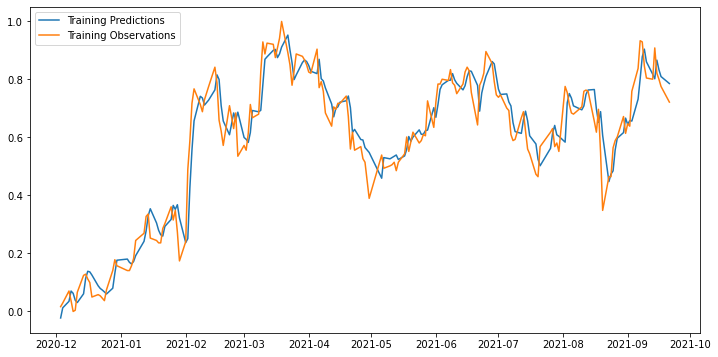

In [12]:
train_predictions = model.predict(X_train).flatten()
plt.figure(figsize=(12,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 5ms/step


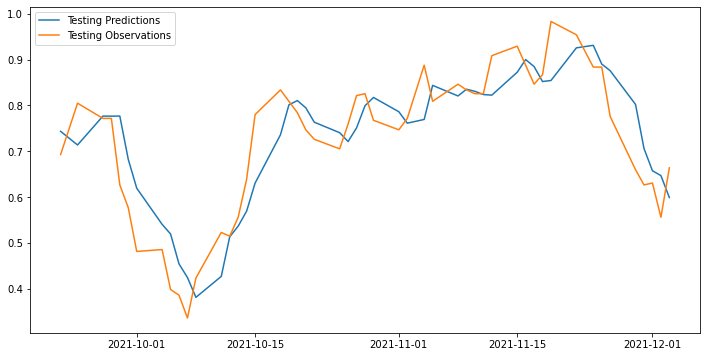

In [13]:
test_predictions = model.predict(X_test).flatten()
plt.figure(figsize=(12,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [14]:
# Convert the scaled values back into real data
y_train_original = min_max_scaler.inverse_transform(y_train)
train_predictions_original = min_max_scaler.inverse_transform(train_predictions.reshape(-1,1))
y_test_original = min_max_scaler.inverse_transform(y_test)
test_predictions_original = min_max_scaler.inverse_transform(test_predictions.reshape(-1,1))

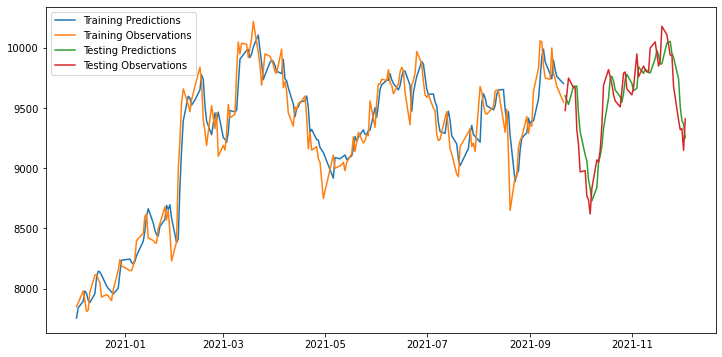

In [15]:
plt.figure(figsize=(12,6))
plt.plot(dates_train, train_predictions_original)
plt.plot(dates_train, y_train_original)
plt.plot(dates_test, test_predictions_original)
plt.plot(dates_test, y_test_original)
plt.legend(['Training Predictions', 'Training Observations','Testing Predictions', 'Testing Observations'])

In [16]:
rmse_scaled = np.sqrt(np.mean(test_predictions - y_test)**2)
print('Root mean squared error scaled:', rmse_scaled)

Root mean squared error scaled: 0.007258108351379633


In [17]:
Predict=pd.read_csv(r'G:\GitHub\Kaggle Tokyo Stock Exchange\jpx-tokyo-stock-exchange-prediction\example_test_files\stock_prices_predict.csv')
Predict.loc[: ,"Date"] = pd.to_datetime(Predict.loc[: ,"Date"], format="%Y-%m-%d")
Predict.index = Predict.pop('Date')
Predict

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
Date,,,,,,,,,,
2021-12-06,20211206_1301,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False
2021-12-06,20211206_1332,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False
2021-12-06,20211206_1333,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False
2021-12-06,20211206_1375,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False
2021-12-06,20211206_1376,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...
2021-12-07,20211207_9990,9990,526.0,535.0,524.0,535.0,57800,1.0,NaN,False
2021-12-07,20211207_9991,9991,795.0,806.0,792.0,805.0,48500,1.0,NaN,False
2021-12-07,20211207_9993,9993,1640.0,1640.0,1620.0,1620.0,6600,1.0,NaN,False


In [18]:
Predict_toyota=Predict[Predict["SecuritiesCode"]==6201]
df_toyota=df_toyota.drop('Target', axis =1)

In [20]:
Predict_toyota=pd.concat([df_toyota, Predict_toyota], axis =0)
Predict_toyota

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
Date,,,,,,,,,,
2017-01-04,20170104_6201,6201,5670.0,5800.0,5650.0,5800.0,429800,1.0,NaN,False
2017-01-05,20170105_6201,6201,5780.0,5810.0,5670.0,5700.0,521600,1.0,NaN,False
2017-01-06,20170106_6201,6201,5610.0,5650.0,5580.0,5610.0,494300,1.0,NaN,False
2017-01-10,20170110_6201,6201,5610.0,5670.0,5560.0,5580.0,537800,1.0,NaN,False
2017-01-11,20170111_6201,6201,5660.0,5690.0,5630.0,5670.0,551400,1.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...
2021-12-01,20211201_6201,6201,9280.0,9410.0,9230.0,9330.0,389300,1.0,NaN,False
2021-12-02,20211202_6201,6201,9210.0,9310.0,9120.0,9150.0,438100,1.0,NaN,False
2021-12-03,20211203_6201,6201,9180.0,9420.0,9090.0,9410.0,391500,1.0,NaN,False


In [22]:
windowed_test = df_to_windowed_df(Predict_toyota, 
                                '2021-12-06', 
                                '2021-12-07', 
                                n=5)
windowed_test

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2021-12-06,9400.0,9320.0,9330.0,9150.0,9410.0,9180.0
1,2021-12-07,9320.0,9330.0,9150.0,9410.0,9180.0,9380.0


In [23]:
dates, X, y = windowed_df_to_date_X_y(windowed_test)

dates.shape, X.shape, y.shape

((2,), (2, 5, 1), (2,))

In [24]:
X_flat = X.reshape(X.shape[0], -1)  # This will flatten the timesteps while keeping the samples intact

# Now apply the MinMaxScaler
X_scaled = min_max_scaler.fit_transform(X_flat)
y_scaled = min_max_scaler.fit_transform(y.reshape(-1, 1))
# reshape it back
X_predict= X_scaled.reshape(X.shape[0], X.shape[1], -1)

In [25]:
Predictions_toyota = model.predict(X_predict).flatten()
Price_prediction_toyota = min_max_scaler.inverse_transform(Predictions_toyota.reshape(-1,1))

1/1 [==============================] - 0s 26ms/step


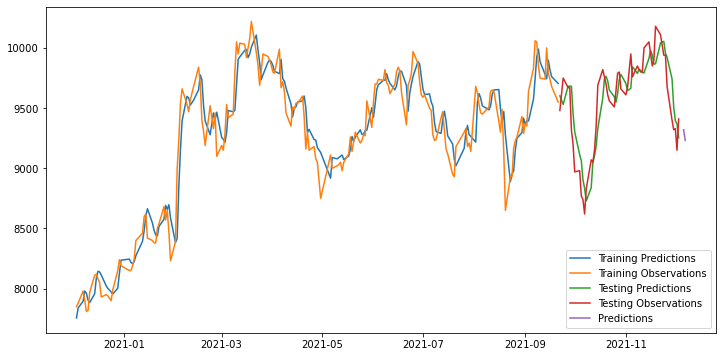

In [26]:
plt.figure(figsize=(12,6))
plt.plot(dates_train, train_predictions_original)
plt.plot(dates_train, y_train_original)
plt.plot(dates_test, test_predictions_original)
plt.plot(dates_test, y_test_original)
plt.plot(dates, Price_prediction_toyota)
plt.legend(['Training Predictions', 'Training Observations','Testing Predictions', 'Testing Observations','Predictions'])

In [27]:
dates_string = ' and '.join([str(date) for date in dates])
predictions_string = ' and '.join([str(prediction[0]) for prediction in Price_prediction_toyota])

print('The predicted price on', dates_string, 'are', predictions_string)

The predicted price on 2021-12-06 00:00:00 and 2021-12-07 00:00:00 are 9320.747 and 9231.117


In [29]:
model.save('LSTM_stockprediction_model.h5')